# **Aprendizaje Supervisado**

En este trabajo se implementará un enfoque de aprendizaje supervisado para construir un modelo capaz de predecir, a partir de las características de personas y la presencia de ciertos objetos, si una imagen corresponde a un frame anómalo o normal.

Dado que el propósito del sistema es detectar comportamientos o situaciones fuera de lo común en entornos de video vigilancia, la métrica más relevante será el recall (sensibilidad), que indica cuántos frames anómalos el modelo logra identificar correctamente. Un valor alto de recall implica que pocos eventos anómalos pasan desapercibidos. No obstante, también se buscará mantener una precisión elevada, para evitar falsas alarmas en exceso.

 Para ello, se utilizó el dataset CamNuvem (https://www.kaggle.com/datasets/louisamakye/camnuvem/data
), el cual contiene diferentes imágenes extraídas de videos de cámaras de seguridad, organizadas en carpetas de entrenamiento y testeo, y clasificadas como normal o anómalo.

A partir de este dataset, se empleó un tracker llamado YOLOv8 para extraer diferentes características de las personas detectadas en cada imagen y el conteo de algunas clases aparte. Estas características se guardaron en dos archivos .csv:

* Uno con información de cada frame como observación individual.
* Otro con un resumen de cada video (conjunto de frames) como observación, incluyendo diferentes flags binarias que indican eventos relevantes.

El archivo de resumen por video se utilizará para el aprendizaje supervisado, con más de 900 observaciones. Los datos se dividirán en un train-test split con proporción 80%-20%, que servirá para entrenar y evaluar 7 modelos diferentes. La estructura de la evaluación es de la siguiente manera:

Modelo X:
1.   Validación cruzada k-fold (5 splits) solo con los datos de entrenamiento (80%).
2.   Calibración de los hiperparámetros más relevantes según la métrica principal (recall)
3.   Evaluación final en el conjunto de test con los hiperparámetros seleccionados.
4.   Análisis mediante matriz de confusión y curva ROC-AUC.
5.   Comparación entre los resultados promedio de la validación cruzada y los del test.

Cada uno de los modelos se evaluara de la manera anteriormente dicha al final se compararan todos los resultados de todos los modelos y se elegira uno que maneje mejor el caso de uso. Cabe resaltar ya que las clases estan bien balancedas (482 anomaly : 472 normal) el umbral sera de 0.5 y el random state para todas las evaluaciones se fijaran en "123".Esto asegura que los resultados sean reproducibles y que la métrica de recall no esté sesgada por un desbalance de clases.






## **Script para creación de datasets (csv.)**

In [ ]:
# Tratar de encontrar la carpeta
import os
base_path = "/content/drive/MyDrive/images"
print("Carpetas en images:", os.listdir(base_path))
print("Carpetas en train:", os.listdir(os.path.join(base_path, "training")))

Carpetas en images: ['test', 'training']
Carpetas en train: ['normal', 'anomaly']


In [ ]:
# Instalar la libreria ultralytics con YOLO
!pip install ultralytics lap
!git clone https://github.com/mikel-brostrom/yolov8_tracking.git
%cd yolov8_tracking

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.2 MB/s eta 0:00:00
Cloning into 'yolov8_tracking'...
remote: Enumerating objects: 19740, done.
remote: Counting objects: 100% (822/822), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 19740 (delta 655), reused 616 (delta 592), pack-reused 18918 (from 3)
Receiving objects: 100% (19740/19740), 129.83 MiB | 32.41 MiB/s, done.
Resolving deltas: 100% (12630/12630), done.
/content/yolov8_tracking


In [ ]:
from ultralytics import YOLO
import os, shutil
import pandas as pd
import re
import numpy as np

model = YOLO("yolov8n.pt")

# Lista de clases relevantes
relevant_objects = {
    0: "person",
    2: "car",
    3: "motorcycle",
    5: "bus",
    24: "backpack",
    26: "handbag",
    28: "suitcase",
    43: "knife",
    63: "laptop",
    67: "cell phone",
}

def natural_sort_key(filename):
    match = re.search(r'frame_(\d+)', filename)
    return int(match.group(1)) if match else float('inf')

def process_split(split, base_path, output_path):
    all_dfs = []

    for cls in ["anomaly", "normal"]:
        folder = os.path.join(base_path, split, cls)

        for video_folder in os.listdir(folder):
            input_folder = os.path.join(folder, video_folder)
            if os.path.isdir(input_folder):
                print(f"Procesando: {input_folder}")

                image_files = [f for f in os.listdir(input_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]
                if not image_files:
                    continue

                image_files.sort(key=natural_sort_key)
                all_rows = []
                previous_frame_data = {}

                for image_file in image_files:
                    image_path = os.path.join(input_folder, image_file)

                    frame_match = re.search(r'frame_(\d+)', image_file)
                    frame_number = int(frame_match.group(1)) if frame_match else 0

                    # Detectar todas las clases relevantes
                    results = model.predict(
                        source=image_path,
                        save=False,
                        save_txt=False,
                        classes=list(relevant_objects.keys()),
                        imgsz=640,
                        conf=0.3
                    )

                    # Inicializar diccionario para columnas binarias de objetos
                    object_presence = {obj_name: 0 for obj_name in relevant_objects.values() if obj_name != "person"}

                    person_detections = []
                    other_objects_detected = []

                    for result in results:
                        if result.boxes is not None and len(result.boxes) > 0:
                            boxes = result.boxes.xyxy.cpu().numpy()
                            confidences = result.boxes.conf.cpu().numpy()
                            class_ids = result.boxes.cls.cpu().numpy().astype(int)

                            for i, (box, conf, cls_id) in enumerate(zip(boxes, confidences, class_ids)):
                                if cls_id in relevant_objects:
                                    obj_name = relevant_objects[cls_id]

                                    if obj_name == "person":
                                        # Procesar personas normalmente
                                        person_detections.append({
                                            'box': box,
                                            'conf': conf,
                                            'cls_id': cls_id,
                                            'index': i
                                        })
                                    else:
                                        # Marcar presencia de otros objetos
                                        object_presence[obj_name] = 1
                                        other_objects_detected.append(obj_name)

                    # Procesar detecciones de personas (cálculos de tracking, etc.)
                    if person_detections:
                        for person_data in person_detections:
                            box = person_data['box']
                            conf = person_data['conf']
                            cls_id = person_data['cls_id']
                            i = person_data['index']

                            width = box[2] - box[0]
                            height = box[3] - box[1]
                            center_x = (box[0] + box[2]) / 2
                            center_y = (box[1] + box[3]) / 2

                            movement_since_last_frame = 0
                            acceleration = 0

                            if frame_number > 0 and f"person_{i}" in previous_frame_data:
                                prev_center_x, prev_center_y = previous_frame_data[f"person_{i}"]
                                movement_since_last_frame = np.sqrt(
                                    (center_x - prev_center_x)**2 +
                                    (center_y - prev_center_y)**2
                                )

                            previous_frame_data[f"person_{i}"] = (center_x, center_y)

                            df_row = pd.DataFrame({
                                "frame_number": [frame_number],
                                "frame_filename": [image_file],
                                "left": [box[0]],
                                "top": [box[1]],
                                "right": [box[2]],
                                "bottom": [box[3]],
                                "confidence": [conf],
                                "class_id": [cls_id],
                                "width": [width],
                                "height": [height],
                                "bbox_area": [width * height],
                                "aspect_ratio": [height / width],
                                "center_x": [center_x],
                                "center_y": [center_y],
                                "movement_since_last_frame": [movement_since_last_frame],
                                "distance_from_center": [np.sqrt((center_x - 320)**2 + (center_y - 240)**2)],
                                "is_large_person": [1 if (width * height) > 10000 else 0],
                                "is_small_person": [1 if (width * height) < 5000 else 0],
                                "is_high_confidence": [1 if conf > 0.8 else 0],
                                "label": [cls],
                                "video_folder": [video_folder],
                                "split": [split],
                                "person_id": [i],
                                "total_persons_in_frame": [len(person_detections)],
                                # Añadir columnas binarias para otros objetos
                                **{f"has_{obj_name}": [object_presence[obj_name]] for obj_name in object_presence}
                            })
                            all_rows.append(df_row)
                    else:
                        # Frame sin personas, pero con información de otros objetos
                        df_row = pd.DataFrame({
                            "frame_number": [frame_number],
                            "frame_filename": [image_file],
                            "left": [None], "top": [None], "right": [None], "bottom": [None],
                            "confidence": [None], "class_id": [None],
                            "width": [None], "height": [None], "bbox_area": [None],
                            "aspect_ratio": [None], "center_x": [None], "center_y": [None],
                            "movement_since_last_frame": [None], "distance_from_center": [None],
                            "is_large_person": [0], "is_small_person": [0], "is_high_confidence": [0],
                            "label": [cls], "video_folder": [video_folder], "split": [split],
                            "person_id": [None], "total_persons_in_frame": [0],
                            # Añadir columnas binarias para otros objetos
                            **{f"has_{obj_name}": [object_presence[obj_name]] for obj_name in object_presence}
                        })
                        all_rows.append(df_row)

                        previous_frame_data = {}

                if all_rows:
                    df_folder = pd.concat(all_rows, ignore_index=True)
                    df_folder = df_folder.sort_values("frame_number").reset_index(drop=True)

                    df_folder = calculate_additional_features(df_folder)

                    all_dfs.append(df_folder)
                    print(f"{video_folder}: {len(image_files)} frames procesados")

    if all_dfs:
        final_df = pd.concat(all_dfs, ignore_index=True)
        final_df = final_df.sort_values(["video_folder", "frame_number"])

        output_csv = os.path.join(output_path, f"{split}_dataset_with_features.csv")
        final_df.to_csv(output_csv, index=False)

        create_ml_features(final_df, split, output_path)

        return final_df
    else:
        print(f"No se generaron datos para {split}")
        return None

def calculate_additional_features(df):
    if len(df) == 0:
        return df

    video_groups = df.groupby('video_folder')

    for video_name, group in video_groups:
        video_indices = group.index

        if len(group) > 1:
            detection_rate = len(group[group['class_id'].notna()]) / len(group)

            avg_persons = group['total_persons_in_frame'].mean()

            df.loc[video_indices, 'video_detection_rate'] = detection_rate
            df.loc[video_indices, 'video_avg_persons'] = avg_persons

    return df

def create_ml_features(df, split, output_path):
    ml_features = []

    # Obtener todas las columnas binarias de objetos
    object_columns = [col for col in df.columns if col.startswith('has_')]

    for video_name, group in df.groupby('video_folder'):
        detected_frames = group[group['class_id'].notna()]

        if len(detected_frames) == 0:
            continue

        # Solo añadir las columnas binarias (1 si aparece al menos una vez en el video)
        object_binary_features = {}
        for obj_col in object_columns:
            obj_name = obj_col.replace('has_', '')
            object_binary_features[obj_col] = 1 if group[obj_col].max() > 0 else 0

        features = {
            'video_name': video_name,
            'label': group['label'].iloc[0],
            'frames_with_detection': len(detected_frames),
            'detection_rate': len(detected_frames) / len(group),
            **object_binary_features  # Solo añadir las columnas binarias
        }

        if len(detected_frames) > 0:
            features.update({
                'mean_confidence': detected_frames['confidence'].mean(),
                'mean_bbox_area': detected_frames['bbox_area'].mean(),
                'mean_movement': detected_frames['movement_since_last_frame'].mean(),
                'max_movement': detected_frames['movement_since_last_frame'].max(),
                'mean_distance_from_center': detected_frames['distance_from_center'].mean(),
                'large_person_ratio': detected_frames['is_large_person'].mean(),
                'high_confidence_ratio': detected_frames['is_high_confidence'].mean(),
                'avg_persons_per_frame': detected_frames['total_persons_in_frame'].mean(),
                'var_movement': detected_frames['movement_since_last_frame'].var(),
                'var_bbox_area': detected_frames['bbox_area'].var(),
                'var_confidence': detected_frames['confidence'].var(),
                'var_persons_per_frame': detected_frames['total_persons_in_frame'].var(),
                'max_persons_per_frame': detected_frames['total_persons_in_frame'].max(),
                'max_bbox_area': detected_frames['bbox_area'].max(),
                'min_bbox_area': detected_frames['bbox_area'].min(),
                'max_confidence': detected_frames['confidence'].max(),
                'min_confidence': detected_frames['confidence'].min(),
                'extreme_movement_count': (detected_frames['movement_since_last_frame'] > 50).sum(),
                'crowd_frames_count': (detected_frames['total_persons_in_frame'] >= 5).sum()
            })

        ml_features.append(features)

    if ml_features:
        ml_df = pd.DataFrame(ml_features)
        ml_csv = os.path.join(output_path, f"{split}_ml_ready.csv")
        ml_df.to_csv(ml_csv, index=False)
        print(f"ML features guardados en: {ml_csv}")
        print(f"Columnas incluidas: {list(ml_df.columns)}")

base_path = "images"
output_path = "features"
os.makedirs(output_path, exist_ok=True)

#df_train = process_split("training", base_path, output_path)
#df_test = process_split("test", base_path, output_path)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## **Preprosecamiento de datos**

En este paso vamos a leer nuestro archivo .csv para luego ver con que variables nos vamos a quedar para el entrenamiento. Tambien vemos las variables binarias las cuales contamos en cuantos videos aparecen. Para las variables que hemos elegidos son las siguientes:

Variables:
1. mean_confidence = Promedio del nivel de confianza que tiene el modelo YOLOv8 al detectar objetos (personas u objetos). Un valor promedio bajo puede indicar un comportamiento sospechoso ya que no es posible detectar.
2. mean_box_area = Promedio del área de las cajas delimitadoras (bounding boxes) detectadas por YOLO en cada frame. Puede medir cuan cerca esta las personas a la camara o cuan alejadas estan.
3. min_bbox_area = Valor mínimo del área del bounding box entre todas las personas detectadas en el frame.
4. max_bbox_area = Valor máximo del área del bounding box en el frame.
5. max_confidence = Máximo valor de confianza entre todas las detecciones del frame.
6. large_person_ratio = Proporción de personas cuyo bounding box supera un umbral de tamaño (por ejemplo, área > media del dataset).
7. high_confidence_ratio = Proporción de detecciones con alta confianza (> 0.8).
8. avg_persons_per_frame = Promedio de personas detectadas por frame en un video.
9. has_car,has_motorcycle = Dos flags binarias de las dos clases que más aparecen en los videos además de las personas.

In [ ]:
# Ponemos nuestros data set
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data
data = pd.read_csv("dataframe_videos.csv")
data.head(1)

,video_name,label,frames_with_detection,detection_rate,has_car,has_motorcycle,has_bus,has_backpack,has_handbag,has_suitcase,...,var_bbox_area,var_confidence,var_persons_per_frame,max_persons_per_frame,max_bbox_area,min_bbox_area,max_confidence,min_confidence,extreme_movement_count,crowd_frames_count
0,10,anomaly,161,0.842932,1,1,0,1,0,0,...,1817018.9,0.02701,5.134472,8,6313.1826,236.63853,0.905809,0.305065,53,66


In [ ]:
# Separamos la variable objetivo y quitamos la variable del nombre del video
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df_numeric = data.drop(columns=["video_name", "label"], errors="ignore")


In [ ]:
binary_cols = [col for col in data.columns if col.startswith("has_")]

# Contamos cuántos 1 y 0 tiene cada columna binaria
for col in binary_cols:
    counts = data[col].value_counts()
    print(f"{col} -> {counts.to_dict()}")

# Se ve que no tenemos solo 3 videos que portan la clase knife.
knife_videos = data[data["has_knife"] == 1]

# Ver su distribución entre "anomaly" y "normal"
print(knife_videos["label"].value_counts())
print(knife_videos[["video_name", "label"]])

# Se concluye que no es necesario la clase knife
data.drop(columns = "has_knife")

has_car -> {0: 575, 1: 379}
has_motorcycle -> {0: 785, 1: 169}
has_bus -> {0: 817, 1: 137}
has_backpack -> {0: 831, 1: 123}
has_handbag -> {0: 766, 1: 188}
has_suitcase -> {0: 747, 1: 207}
has_knife -> {0: 951, 1: 3}
has_laptop -> {0: 817, 1: 137}
has_cell phone -> {0: 885, 1: 69}
label
normal     2
anomaly    1
Name: count, dtype: int64
                video_name    label
337                    341  anomaly
767  Normal_Videos283_x264   normal
858  Normal_Videos386_x264   normal


,video_name,label,frames_with_detection,detection_rate,has_car,has_motorcycle,has_bus,has_backpack,has_handbag,has_suitcase,...,var_bbox_area,var_confidence,var_persons_per_frame,max_persons_per_frame,max_bbox_area,min_bbox_area,max_confidence,min_confidence,extreme_movement_count,crowd_frames_count
0,10,anomaly,161,0.842932,1,1,0,1,0,0,...,1817018.90,0.027010,5.134472,8,6313.1826,236.638530,0.905809,0.305065,53,66
1,113,anomaly,47,0.546512,1,0,0,0,0,0,...,155422.62,0.018027,0.738205,3,1737.8933,173.078030,0.783703,0.346587,9,0
2,119,anomaly,62,0.898551,0,0,0,0,0,0,...,21070118.00,0.030463,0.432575,3,16115.2410,1319.852400,0.913675,0.306606,18,0
3,142,anomaly,534,1.000000,0,0,0,0,0,1,...,23765720.00,0.036836,2.854214,9,35963.6130,223.581820,0.926798,0.300101,261,348
4,143,anomaly,251,0.976654,0,0,0,0,0,0,...,9373668.00,0.034106,0.938008,5,14477.7360,587.421940,0.891798,0.303958,82,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,Normal_Videos485_x264,normal,56,0.875000,1,0,0,0,0,0,...,68079.06,0.032010,0.985714,4,1595.6350,186.954900,0.832498,0.327667,12,0
950,Normal_Videos486_x264,normal,185,0.864486,1,0,1,0,0,0,...,166684.14,0.024252,2.597944,8,2282.8340,94.580185,0.861098,0.300642,76,56
951,Normal_Videos487_x264,normal,25,0.961538,1,0,0,0,0,0,...,76239.58,0.019378,1.000000,4,1020.9548,84.642410,0.788417,0.316674,12,0
952,Normal_Videos488_x264,normal,77,0.905882,1,0,0,1,0,0,...,264487.53,0.021902,1.210526,5,1939.1199,184.753330,0.874872,0.332474,14,5


In [ ]:
# Preparamos nuestras variables
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
vars = data[['mean_confidence',
             'mean_bbox_area',
             'min_bbox_area',
             'max_confidence',
             'max_bbox_area',
             'large_person_ratio',
             'high_confidence_ratio',
             'avg_persons_per_frame',
             'has_car',
             'has_motorcycle',
             ]]

x = vars
data['label_encoded'] = data['label'].map({'normal': 0, 'anomaly': 1})

y = data['label_encoded']


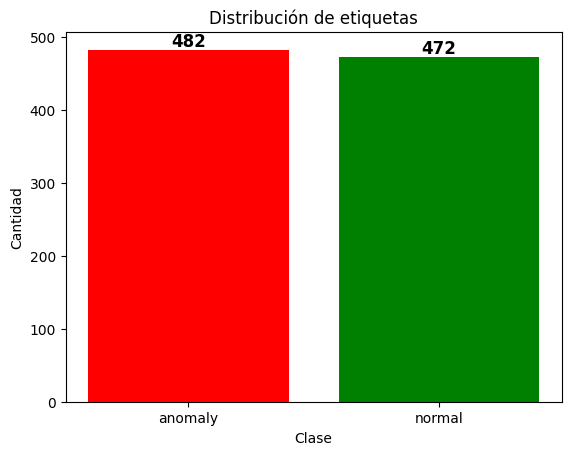

In [ ]:
# Conteo total por clase
conteo = data['label_encoded'].value_counts()

mapeo = {0: "normal", 1: "anomaly"}
plt.bar(conteo.index.map(mapeo), conteo.values, color=['red', 'green'])
plt.title('Distribución de etiquetas')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
for i, valor in enumerate(conteo.values):
    plt.text(i, valor + 5, str(valor), ha='center', fontsize=12, fontweight='bold')

plt.show()

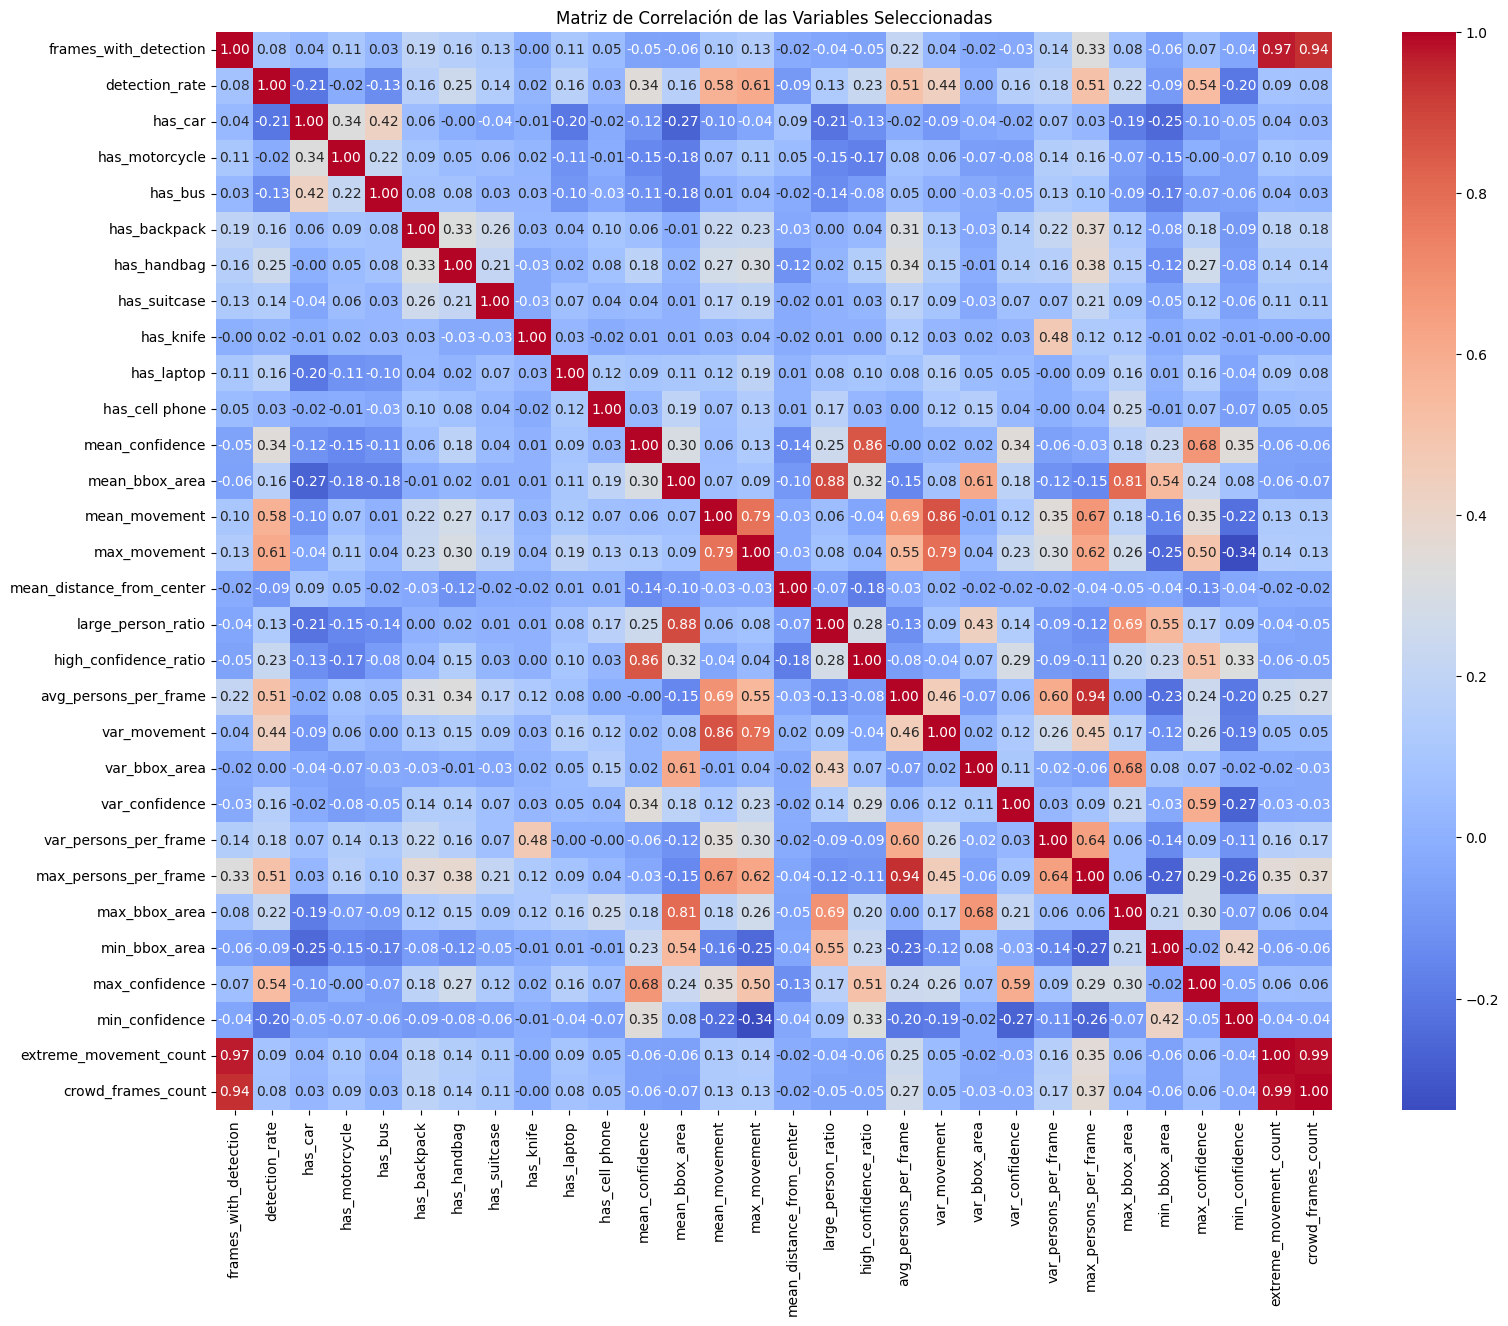

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Calcular la matriz de correlación
correlation_matrix = df_numeric.corr()

# Visualizar la matriz de correlación como un mapa de calor
plt.figure(figsize=(18, 14)) # Aumentar el tamaño de la figura
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de las Variables Seleccionadas')
plt.show()


In [ ]:
# Train test-split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, stratify=y)

print(x_train.shape)
print(x_test.shape)

(763, 10)
(191, 10)


In [ ]:
# Escalamos los datos
from sklearn.preprocessing import StandardScaler

esc = StandardScaler()
x_train_scaled = esc.fit_transform(x_train)
x_test_scaled = esc.transform(x_test)

## **Modelo 1: Random Forest**

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

modelo_rf = RandomForestClassifier(n_estimators=200,max_depth=5,class_weight="balanced", random_state=123)

scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

resultados = recall_scores = cross_validate(modelo_rf, x_train, y_train, cv=cv, scoring=scoring)

df_resultados = pd.DataFrame({
    'Fold': range(1, cv.get_n_splits() + 1),
    'Recall': resultados['test_recall'],
    'Precision': resultados['test_precision'],
    'F1': resultados['test_f1'],
    'ROC_AUC': resultados['test_roc_auc']
})

promedios = pd.DataFrame({
    'Fold': ['Promedio'],
    'Recall': [df_resultados['Recall'].mean()],
    'Precision': [df_resultados['Precision'].mean()],
    'F1': [df_resultados['F1'].mean()],
    'ROC_AUC': [df_resultados['ROC_AUC'].mean()]
})

df_resultados = pd.concat([df_resultados, promedios], ignore_index=True)

df_resultados

,Fold,Recall,Precision,F1,ROC_AUC
0,1,0.792208,0.824324,0.807947,0.870472
1,2,0.675325,0.764706,0.717241,0.808783
2,3,0.662338,0.718310,0.689189,0.794087
3,4,0.818182,0.759036,0.787500,0.849870
4,5,0.883117,0.772727,0.824242,0.880173
5,Promedio,0.766234,0.767821,0.765224,0.840677


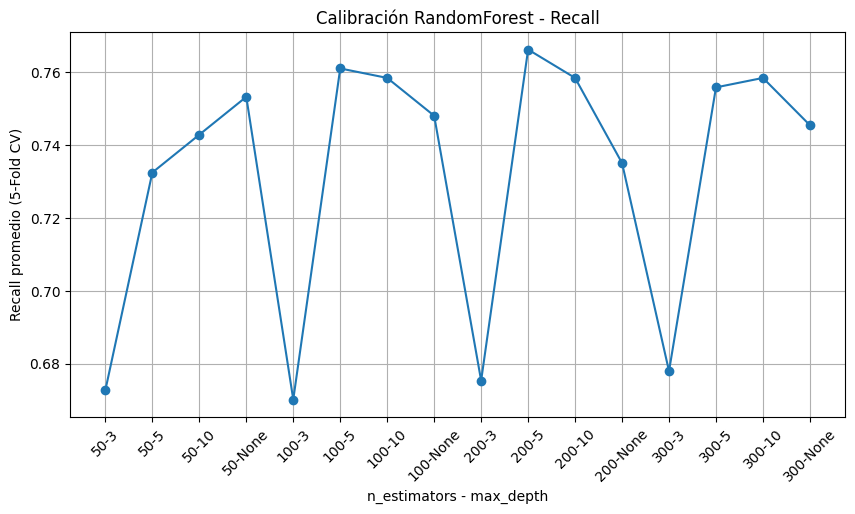

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

n_estimators_list = [50, 100, 200, 300]
max_depth_list = [3, 5, 10, None]

recall_promedios = []

for n in n_estimators_list:
    for d in max_depth_list:
        modelo_rf = RandomForestClassifier(
            n_estimators=n,
            max_depth=d,
            class_weight="balanced",
            random_state=123
        )

        resultados = cross_validate(
            modelo_rf, x_train, y_train, cv=cv,
            scoring = {
              'recall': 'recall',
              },
            n_jobs=-1
        )

        recall_prom = resultados['test_recall'].mean()
        recall_promedios.append((n, d, recall_prom))

valores = [f"{n}-{d}" for n,d,_ in recall_promedios]
recalls = [r for _,_,r in recall_promedios]

plt.figure(figsize=(10,5))
plt.plot(valores, recalls, marker='o')
plt.xticks(rotation=45)
plt.ylabel("Recall promedio (5-Fold CV)")
plt.xlabel("n_estimators - max_depth")
plt.title("Calibración RandomForest - Recall")
plt.grid(True)
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc
from sklearn.metrics import roc_auc_score , roc_curve , f1_score

modelo_rf = RandomForestClassifier(n_estimators=200,max_depth=5,class_weight="balanced", random_state=123)
modelo_rf.fit(x_train, y_train)

y_preds_rf = modelo_rf.predict(x_test)
y_preds_rf_proba = modelo_rf.predict_proba(x_test)[:,1]

recall_split = recall_score(y_test,y_preds_rf)
precision_split = precision_score(y_test,y_preds_rf)
f1_split = f1_score(y_test,y_preds_rf)
roc_auc_split = roc_auc_score(y_test, y_preds_rf_proba)
print("Recall Score:", recall_score(y_test,y_preds_rf))
print("Precision Score:", precision_score(y_test,y_preds_rf))
print("F1 Score:", f1_score(y_test,y_preds_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_preds_rf_proba))


Recall Score: 0.7731958762886598
Precision Score: 0.7575757575757576
F1 Score: 0.7653061224489796
ROC-AUC: 0.8544636981794252


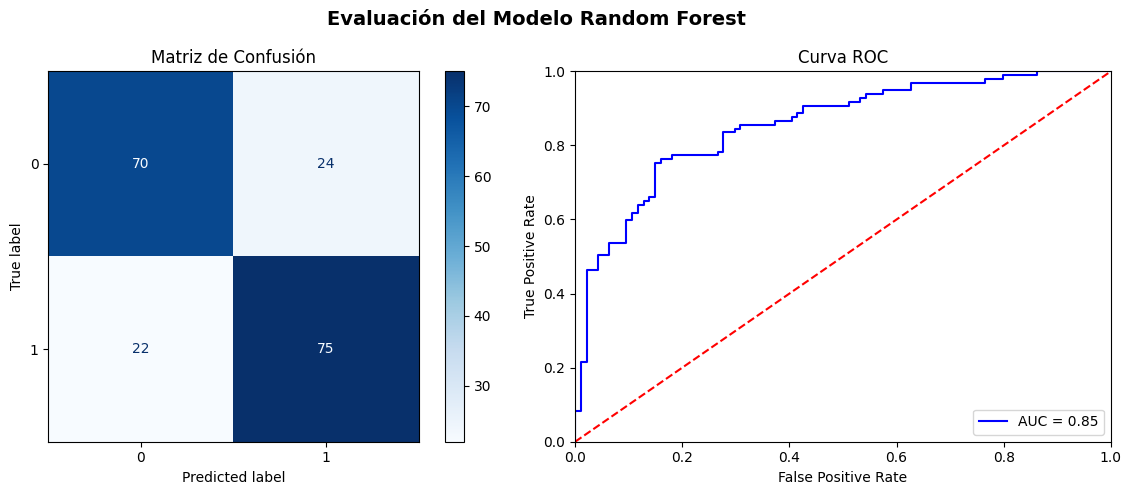

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, RocCurveDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

probs = modelo_rf.predict_proba(x_test)
preds_prob = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, preds_prob)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], 'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

preds = modelo_rf.predict(x_test)
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Matriz de Confusión")

plt.suptitle("Evaluación del Modelo Random Forest", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
promedio_kfold = df_resultados.iloc[-1]

tabla_comparativa = pd.DataFrame({
    'Método': ['Train/Test Split', 'K-Fold (5)'],
    'Recall': [recall_split, promedio_kfold['Recall']],
    'Precision': [precision_split, promedio_kfold['Precision']],
    'F1': [f1_split, promedio_kfold['F1']],
    'ROC_AUC': [roc_auc_split, promedio_kfold['ROC_AUC']]
})

tabla_comparativa



,Método,Recall,Precision,F1,ROC_AUC
0,Train/Test Split,0.773196,0.757576,0.765306,0.854464
1,K-Fold (5),0.766234,0.767821,0.765224,0.840677


### **Análisis comparativo en el modelo Random Forest**
Se puede observar de los resultados que el modelo tiene rendimientos parecidos en los dos métodos de validación aplicados. Aunque se destaca que este modelo trabaja mejor al ser probado en varios subconjuntos que con solo una partición aleatoria del dataset. Esto se puede observar al ver un aumento en la métrica recall y F1 lo que indica mejor capacidad de generalización. La ligera disminución en ROC-AUC indica que en algunos folds el modelo tuvo dificultad para separar correctamente las clases. Pero en general presenta un equilibrio entre precisión y sensibilidad.

## **Modelo 2: Regresión Logistica**

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

lr = LogisticRegression(random_state=123)

scoring = {
    'recall': 'recall',
    'accuracy': 'accuracy',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

resultados = recall_scores = cross_validate(lr, x_train_scaled, y_train, cv=cv, scoring=scoring)

df_resultados = pd.DataFrame({
    'Fold': range(1, cv.get_n_splits() + 1),
    'Recall': resultados['test_recall'],
    'Precision': resultados['test_precision'],
    'F1': resultados['test_f1'],
    'ROC_AUC': resultados['test_roc_auc']
})

promedios = pd.DataFrame({
    'Fold': ['Promedio'],
    'Recall': [df_resultados['Recall'].mean()],
    'Precision': [df_resultados['Precision'].mean()],
    'F1': [df_resultados['F1'].mean()],
    'ROC_AUC': [df_resultados['ROC_AUC'].mean()]
})

df_resultados_lr = pd.concat([df_resultados, promedios], ignore_index=True)

df_resultados_lr

,Fold,Recall,Precision,F1,ROC_AUC
0,1,0.753247,0.763158,0.758170,0.817327
1,2,0.701299,0.771429,0.734694,0.808783
2,3,0.753247,0.763158,0.758170,0.829631
3,4,0.753247,0.743590,0.748387,0.807273
4,5,0.831169,0.752941,0.790123,0.846234
5,Promedio,0.758442,0.758855,0.757909,0.821850


In [ ]:
from sklearn.linear_model import LogisticRegression

modelo_lr = LogisticRegression(random_state=123)
modelo_lr.fit(x_train_scaled, y_train)

y_preds_lr = modelo_lr.predict(x_test_scaled)
y_preds_lr_proba = modelo_lr.predict_proba(x_test_scaled)[:,1]

recall_split_lr = recall_score(y_test,y_preds_lr)
precision_split_lr = precision_score(y_test,y_preds_lr)
f1_split_lr = f1_score(y_test,y_preds_lr)
roc_auc_split_lr = roc_auc_score(y_test, y_preds_lr_proba)

print("Recall Score:", recall_score(y_test,y_preds_lr))
print("Precision Score:", precision_score(y_test,y_preds_lr))
print("F1 Score:", f1_score(y_test,y_preds_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_preds_lr_proba))

Recall Score: 0.7731958762886598
Precision Score: 0.7575757575757576
F1 Score: 0.7653061224489796
ROC-AUC: 0.8292388681728449


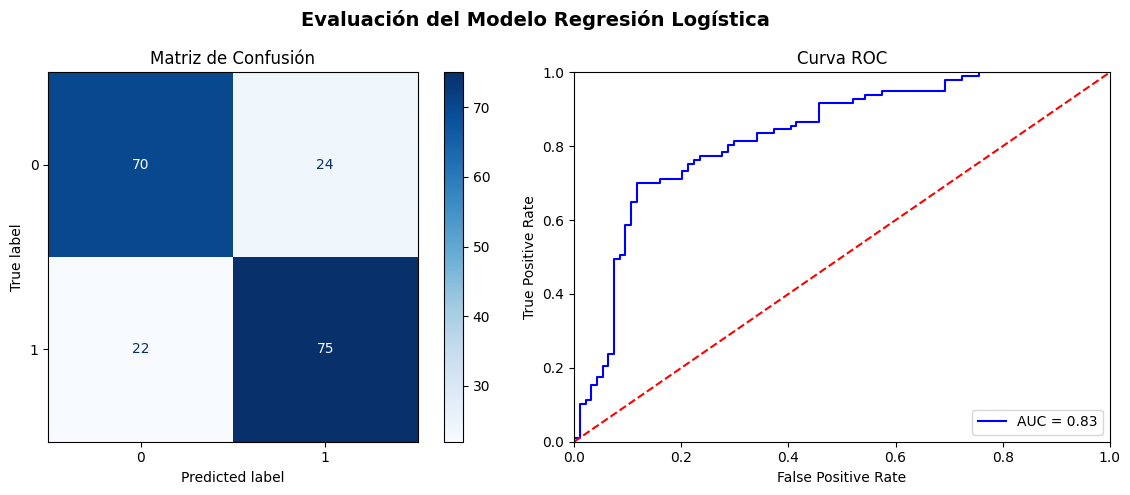

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, RocCurveDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

probs = modelo_lr.predict_proba(x_test_scaled)
preds_prob = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, preds_prob)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], 'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

preds = modelo_lr.predict(x_test_scaled)
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Matriz de Confusión")

plt.suptitle("Evaluación del Modelo Regresión Logística", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
promedio_kfold = df_resultados_lr.iloc[-1]

tabla_comparativa = pd.DataFrame({
    'Método': ['Train/Test Split', 'K-Fold (5)'],
    'Recall': [recall_split_lr, promedio_kfold['Recall']],
    'Precision': [precision_split_lr, promedio_kfold['Precision']],
    'F1': [f1_split_lr, promedio_kfold['F1']],
    'ROC_AUC': [roc_auc_split_lr, promedio_kfold['ROC_AUC']]
})

tabla_comparativa


,Método,Recall,Precision,F1,ROC_AUC
0,Train/Test Split,0.773196,0.757576,0.765306,0.829239
1,K-Fold (5),0.758442,0.758855,0.757909,0.821850


### **Análisis comparativo en el modelo Regresión Logistica**
Ahora con los resultados del modelo de Regresión Logística podemos observar una ligera disminución de capacidad discriminatoria entre las clases ya que al ser un modelo lineal no tiene la misma capacidad que con un modelo más complejo. Tambien podemos observar que el modelo detecta un poco menos de casos positivos cuando se entrena en distintos subconjuntos. Esto puede ser que en algunos folds las variables no tienen una relación no lineal entre ellas como si las tienen en otras.

## **Modelo 3: KNN (K-nearest-neighbors)**

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

knn = KNeighborsClassifier(n_neighbors=19)

scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

resultados = recall_scores = cross_validate(knn, x_train_scaled, y_train, cv=cv, scoring=scoring)

df_resultados = pd.DataFrame({
    'Fold': range(1, cv.get_n_splits() + 1),
    'Recall': resultados['test_recall'],
    'Precision': resultados['test_precision'],
    'F1': resultados['test_f1'],
    'ROC_AUC': resultados['test_roc_auc']
})

promedios = pd.DataFrame({
    'Fold': ['Promedio'],
    'Recall': [df_resultados['Recall'].mean()],
    'Precision': [df_resultados['Precision'].mean()],
    'F1': [df_resultados['F1'].mean()],
    'ROC_AUC': [df_resultados['ROC_AUC'].mean()]
})

df_resultados_knn = pd.concat([df_resultados, promedios], ignore_index=True)

df_resultados_knn

,Fold,Recall,Precision,F1,ROC_AUC
0,1,0.766234,0.694118,0.728395,0.793660
1,2,0.740260,0.721519,0.730769,0.785458
2,3,0.831169,0.680851,0.748538,0.779990
3,4,0.831169,0.673684,0.744186,0.782771
4,5,0.883117,0.747253,0.809524,0.856797
5,Promedio,0.810390,0.703485,0.752282,0.799735


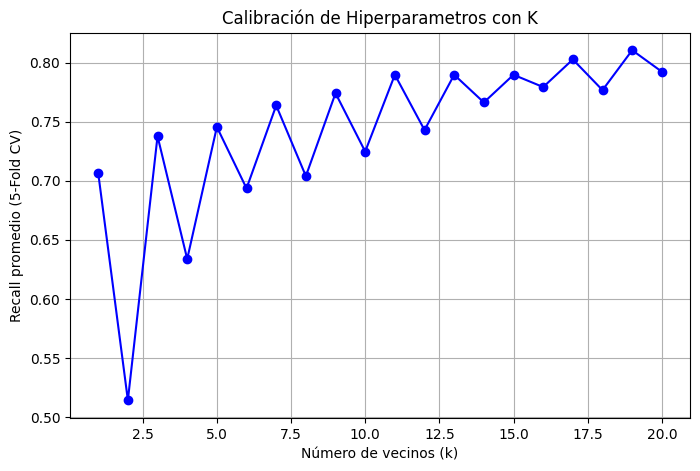

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

k_values = np.arange(1, 21)

recall_promedios = []

for k in k_values:
    modelo_knn_k = KNeighborsClassifier(n_neighbors=k)

    resultados = cross_validate(
        modelo_knn_k, x_train_scaled, y_train, cv=cv,
        scoring={
            'recall': 'recall',
        },
        n_jobs=-1
    )

    recall_prom = resultados['test_recall'].mean()
    recall_promedios.append(recall_prom)

plt.figure(figsize=(8,5))
plt.plot(k_values, recall_promedios, marker='o', color='blue')
plt.xlabel("Número de vecinos (k)")
plt.ylabel("Recall promedio (5-Fold CV)")
plt.title("Calibración de Hiperparametros con K")
plt.grid(True)
plt.show()



In [ ]:
# Mejor parametro k
modelo_knn = KNeighborsClassifier(n_neighbors=19)
modelo_knn.fit(x_train_scaled, y_train)

y_preds_knn = modelo_knn.predict(x_test_scaled)
y_preds_knn_proba = modelo_knn.predict_proba(x_test_scaled)[:,1]

recall_split_knn = recall_score(y_test,y_preds_knn)
precision_split_knn = precision_score(y_test,y_preds_knn)
f1_split_knn = f1_score(y_test,y_preds_knn)
roc_auc_split_knn = roc_auc_score(y_test, y_preds_knn_proba)

print("Recall Score:", recall_score(y_test,y_preds_knn))
print("Precision Score:", precision_score(y_test,y_preds_knn))
print("F1 Score:", f1_score(y_test,y_preds_knn))
print("ROC-AUC:", roc_auc_score(y_test,y_preds_knn_proba))

Recall Score: 0.7835051546391752
Precision Score: 0.7307692307692307
F1 Score: 0.7562189054726368
ROC-AUC: 0.8434415441982891


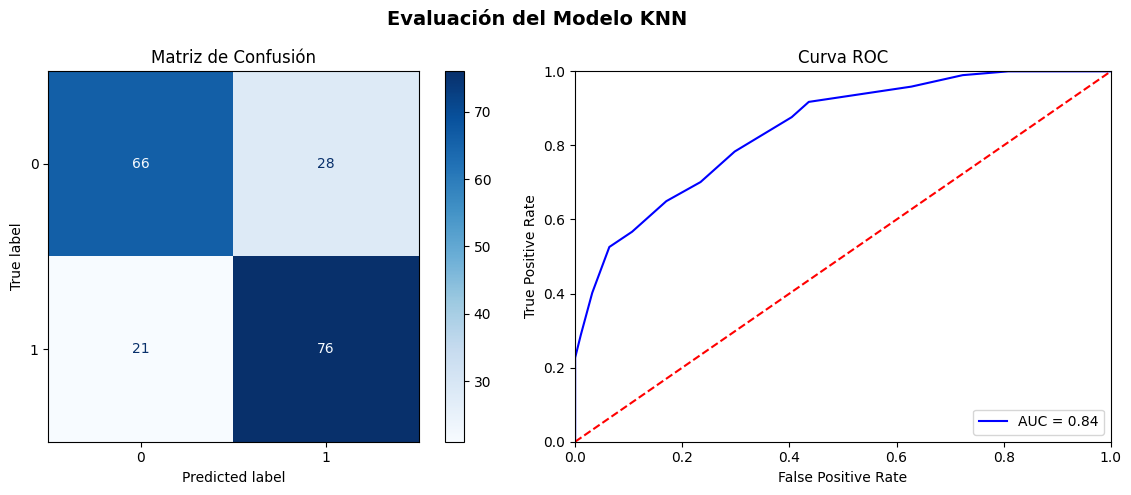

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, RocCurveDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

probs = modelo_knn.predict_proba(x_test_scaled)
preds_prob = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, preds_prob)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], 'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

preds = modelo_knn.predict(x_test_scaled)
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Matriz de Confusión")

plt.suptitle("Evaluación del Modelo KNN", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
promedio_kfold = df_resultados_knn.iloc[-1]

tabla_comparativa = pd.DataFrame({
    'Método': ['Train/Test Split', 'K-Fold (5)'],
    'Recall': [recall_split_knn, promedio_kfold['Recall']],
    'Precision': [precision_split_knn, promedio_kfold['Precision']],
    'F1': [f1_split_knn, promedio_kfold['F1']],
    'ROC_AUC': [roc_auc_split_knn, promedio_kfold['ROC_AUC']]
})

tabla_comparativa


,Método,Recall,Precision,F1,ROC_AUC
0,Train/Test Split,0.783505,0.730769,0.756219,0.843442
1,K-Fold (5),0.810390,0.703485,0.752282,0.799735


### **Análisis comparativo en el modelo KNN**
Para el modelo KNN ya con su hiperparametro calibrado en K=19, se puede observar un alto recall, especialmente en la validación cruzada, lo que indica que el modelo es el mejor por ahora en detectar la mayoría de los casos positivos. Pero este incremento en la sensibilidad viene acompañado de una ligera disminución en la precisión, en la parte de los folds, esto puede deberse a que el modelo KNN prioriza la detección cercanos tratando de aumentar la probabilidad de clasificar correctamente los casos positivos, pero eso conlleva a que etiquete por error algunos normales como anormales. Aún asi el modelo mantiene un ROC-AUC estable esto demuestra que posee una buena capacidad discriminatoria global entre clases. Aunque cabe recalcar si K fuera más pequeño al estar el modelo muy dependiente de los datos específicos de cada fold, podría tender a sobreajustar.

## **Modelo 4: SVM (Support Vector Machine)**

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.svm import SVC

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

svm = SVC(kernel='linear', C=100, probability=True, random_state=123)

scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

resultados = cross_validate(svm, x_train_scaled, y_train, cv=cv, scoring=scoring)

df_resultados = pd.DataFrame({
    'Fold': range(1, cv.get_n_splits() + 1),
    'Recall': resultados['test_recall'],
    'Precision': resultados['test_precision'],
    'F1': resultados['test_f1'],
    'ROC_AUC': resultados['test_roc_auc']
})

promedios = pd.DataFrame({
    'Fold': ['Promedio'],
    'Recall': [df_resultados['Recall'].mean()],
    'Precision': [df_resultados['Precision'].mean()],
    'F1': [df_resultados['F1'].mean()],
    'ROC_AUC': [df_resultados['ROC_AUC'].mean()]
})

df_resultados_svm = pd.concat([df_resultados, promedios], ignore_index=True)

df_resultados_svm


,Fold,Recall,Precision,F1,ROC_AUC
0,1,0.714286,0.743243,0.728477,0.810321
1,2,0.779221,0.750000,0.764331,0.813568
2,3,0.766234,0.776316,0.771242,0.820745
3,4,0.766234,0.756410,0.761290,0.818355
4,5,0.818182,0.759036,0.787500,0.849870
5,Promedio,0.768831,0.757001,0.762568,0.822572


C=0.001: recall mean=0.2416, std=0.0607
C=0.01: recall mean=0.6182, std=0.0832
C=0.1: recall mean=0.7481, std=0.0424
C=1: recall mean=0.7532, std=0.0385
C=10: recall mean=0.7636, std=0.0343
C=100: recall mean=0.7662, std=0.0376
C=1000: recall mean=0.7662, std=0.0376


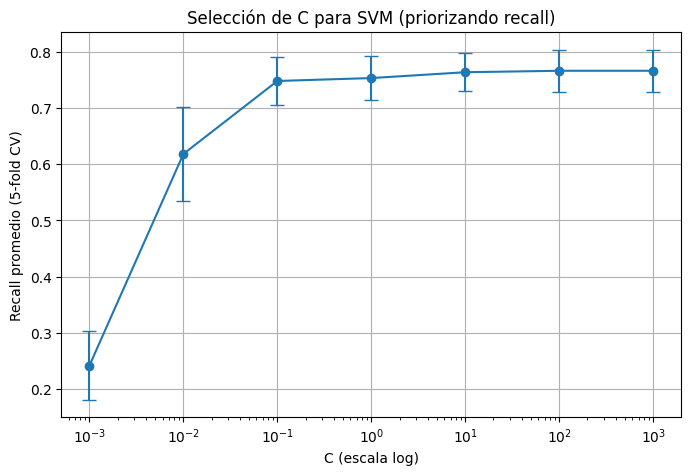

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score

C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

recall_means = []
recall_stds = []

for C in C_values:
    svm = SVC(kernel='linear', C=C, class_weight='balanced', probability=False, random_state=123)
    scores = cross_val_score(svm, x_train_scaled, y_train, cv=cv, scoring='recall', n_jobs=-1)
    recall_means.append(scores.mean())
    recall_stds.append(scores.std())
    print(f"C={C}: recall mean={scores.mean():.4f}, std={scores.std():.4f}")

plt.figure(figsize=(8,5))
plt.errorbar(C_values, recall_means, yerr=recall_stds, fmt='-o', capsize=5)
plt.xscale('log')
plt.xlabel('C (escala log)')
plt.ylabel('Recall promedio (5-fold CV)')
plt.title('Selección de C para SVM (priorizando recall)')
plt.grid(True)
plt.show()



In [ ]:
from sklearn.svm import SVC

modelo_svm = SVC(kernel='linear', C = 100,probability=True,random_state=123)
modelo_svm.fit(x_train_scaled, y_train)

y_preds_svm = modelo_svm.predict(x_test_scaled)
y_preds_svm_proba = modelo_svm.predict_proba(x_test_scaled)[:,1]

recall_split_svm = recall_score(y_test,y_preds_svm)
precision_split_svm = precision_score(y_test,y_preds_svm)
f1_split_svm = f1_score(y_test,y_preds_svm)
roc_auc_split_svm = roc_auc_score(y_test, y_preds_svm_proba)

print("Recall Score:", recall_split_svm)
print("Precision Score:", precision_split_svm)
print("F1 Score:",f1_split_svm)
print("ROC AUC:",roc_auc_split_svm)


Recall Score: 0.7938144329896907
Precision Score: 0.7549019607843137
F1 Score: 0.7738693467336684
ROC AUC: 0.8207940337793376


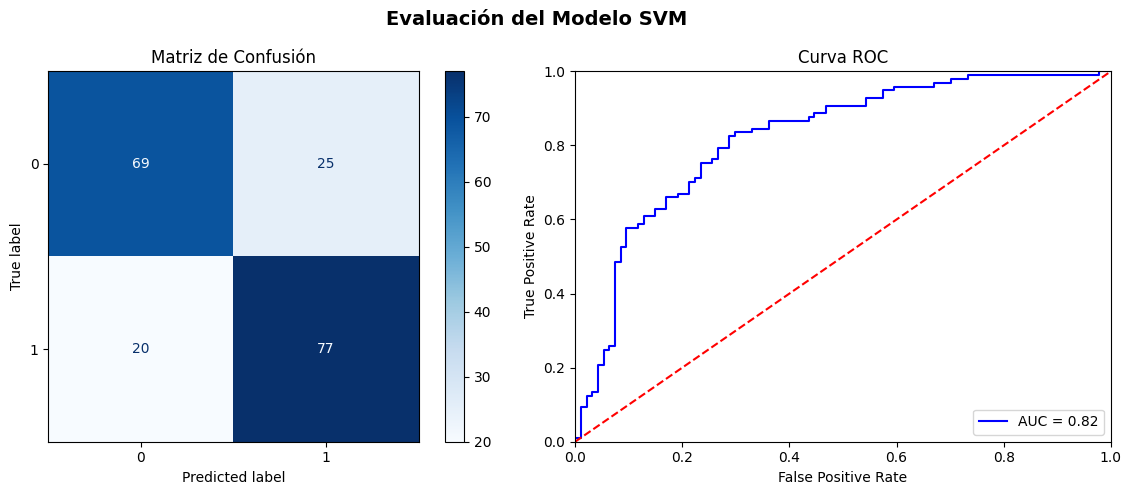

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

probs = modelo_svm.predict_proba(x_test_scaled)
preds_prob = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, preds_prob)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], 'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

preds = modelo_svm.predict(x_test_scaled)
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Matriz de Confusión")

plt.suptitle("Evaluación del Modelo SVM", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
promedio_kfold = df_resultados_svm.iloc[-1]

tabla_comparativa = pd.DataFrame({
    'Método': ['Train/Test Split', 'K-Fold (5)'],
    'Recall': [recall_split_svm, promedio_kfold['Recall']],
    'Precision': [precision_split_svm, promedio_kfold['Precision']],
    'F1': [f1_split_svm, promedio_kfold['F1']],
    'ROC_AUC': [roc_auc_split_svm, promedio_kfold['ROC_AUC']]
})

tabla_comparativa

,Método,Recall,Precision,F1,ROC_AUC
0,Train/Test Split,0.793814,0.754902,0.773869,0.820794
1,K-Fold (5),0.768831,0.757001,0.762568,0.822572


### **Análisis comparativo en el modelo SVM**
Para el modelo SVM (C=100) se observa que el recall sigue siendo alto, especialmente en el split de train/test. Además la percisión se mantiene muy alta, aunque al poner que el modelo sea más estricto empieza a generar algunos falsos positivos al tratar de capturar todos los positivos posibles. Por otro lado al comparlo con la evaluación con K-FOLD se nota una caída en recall, lo que indica que en algunos folds o particiones del dataset no representan perfectamente los patrones de anomalías y el modelo no puede generalizar bien. Aún asi se esperaba un recall aun más elevado con el modelo SVM ya que este tiende a priorizar la detección de positivos frente a minimizar falsos positivos.

## **Modelo 5: XGBoost**

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from xgboost import XGBClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

xgb = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=123)

scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

resultados = cross_validate(xgb, x_train, y_train, cv=cv, scoring=scoring)

df_resultados = pd.DataFrame({
    'Fold': range(1, cv.get_n_splits() + 1),
    'Recall': resultados['test_recall'],
    'Precision': resultados['test_precision'],
    'F1': resultados['test_f1'],
    'ROC_AUC': resultados['test_roc_auc']
})

promedios = pd.DataFrame({
    'Fold': ['Promedio'],
    'Recall': [df_resultados['Recall'].mean()],
    'Precision': [df_resultados['Precision'].mean()],
    'F1': [df_resultados['F1'].mean()],
    'ROC_AUC': [df_resultados['ROC_AUC'].mean()]
})

df_resultados_xgb = pd.concat([df_resultados, promedios], ignore_index=True)

df_resultados_xgb



,Fold,Recall,Precision,F1,ROC_AUC
0,1,0.766234,0.819444,0.791946,0.858595
1,2,0.727273,0.708861,0.717949,0.774863
2,3,0.636364,0.720588,0.675862,0.780332
3,4,0.844156,0.755814,0.797546,0.837835
4,5,0.870130,0.770115,0.817073,0.863636
5,Promedio,0.768831,0.754964,0.760075,0.823052


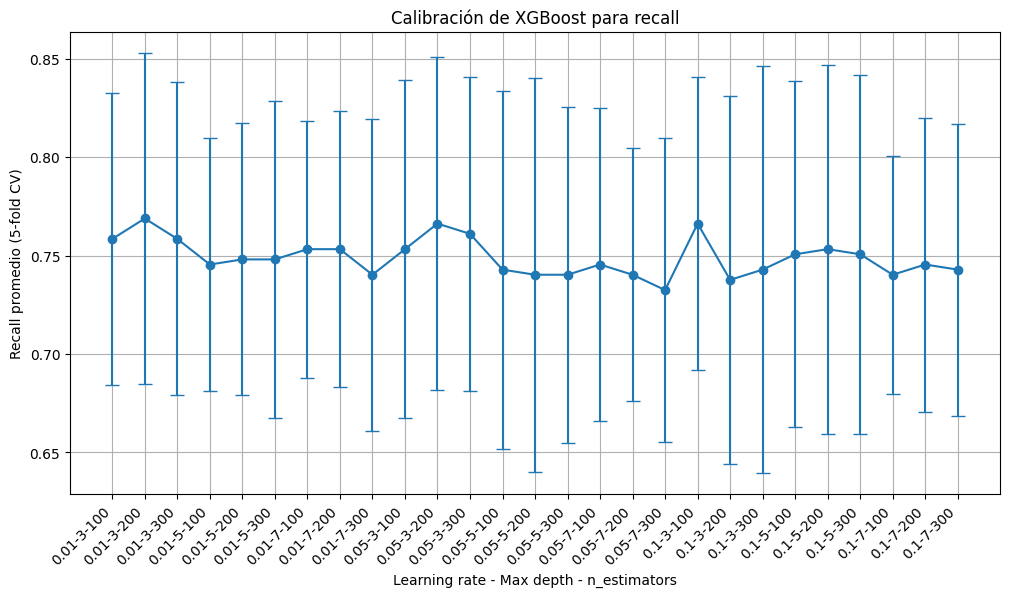

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score

learning_rates = [0.01, 0.05, 0.1]
max_depths = [3, 5, 7]
n_estimators_list = [100, 200, 300]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

resultados = []

for lr in learning_rates:
    for depth in max_depths:
        for n_est in n_estimators_list:
            xgb = XGBClassifier(
                learning_rate=lr,
                max_depth=depth,
                n_estimators=n_est,
                random_state=123
            )

            scores = cross_val_score(
                xgb, x_train, y_train,
                cv=cv, scoring='recall', n_jobs=-1
            )

            resultados.append((lr, depth, n_est, scores.mean(), scores.std()))


labels = [f"{lr}-{depth}-{n}" for lr, depth, n, _, _ in resultados]
recalls = [r for _, _, _, r, _ in resultados]
stds = [s for _, _, _, _, s in resultados]

plt.figure(figsize=(12,6))
plt.errorbar(labels, recalls, yerr=stds, fmt='-o', capsize=5)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Learning rate - Max depth - n_estimators")
plt.ylabel("Recall promedio (5-fold CV)")
plt.title("Calibración de XGBoost para recall")
plt.grid(True)
plt.show()


In [ ]:
modelo_xgb = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=200, random_state=123)
modelo_xgb.fit(x_train, y_train)

y_probs = modelo_xgb.predict_proba(x_test)[:, 1]
y_preds_xgb = modelo_xgb.predict(x_test)

recall_split_xgb = recall_score(y_test,y_preds_xgb)
precision_split_xgb = precision_score(y_test,y_preds_xgb)
f1_split_xgb = f1_score(y_test,y_preds_xgb)
roc_auc_split_xgb = roc_auc_score(y_test, y_probs)

print("Recall Score:", recall_score(y_test,y_preds_xgb))
print("Precision Score:", precision_score(y_test,y_preds_xgb))
print("F1 Score:", f1_score(y_test,y_preds_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_probs))

Recall Score: 0.8144329896907216
Precision Score: 0.7745098039215687
F1 Score: 0.7939698492462312
ROC-AUC: 0.8447576222855889


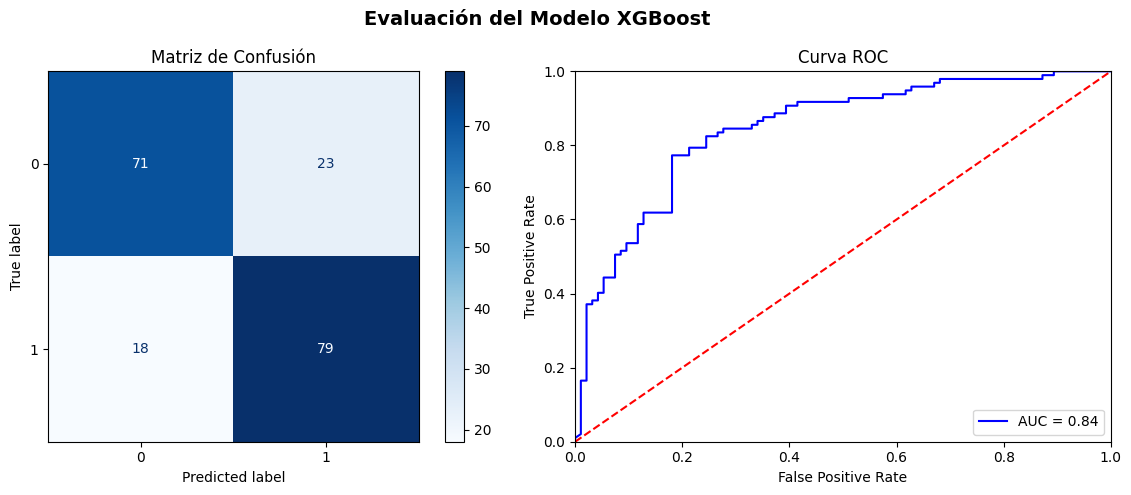

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

probs = modelo_xgb.predict_proba(x_test)
preds_prob = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, preds_prob)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], 'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

preds = modelo_xgb.predict(x_test)
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Matriz de Confusión")

plt.suptitle("Evaluación del Modelo XGBoost", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
promedio_kfold = df_resultados_xgb.iloc[-1]

tabla_comparativa = pd.DataFrame({
    'Método': ['Train/Test Split', 'K-Fold (5)'],
    'Recall': [recall_split_xgb, promedio_kfold['Recall']],
    'Precision': [precision_split_xgb, promedio_kfold['Precision']],
    'F1': [f1_split_xgb, promedio_kfold['F1']],
    'ROC_AUC': [roc_auc_split_xgb, promedio_kfold['ROC_AUC']]
})

tabla_comparativa

,Método,Recall,Precision,F1,ROC_AUC
0,Train/Test Split,0.814433,0.774510,0.793970,0.844758
1,K-Fold (5),0.768831,0.754964,0.760075,0.823052


### **Análisis comparativo en el modelo XGBoost**
Al ver los resultados del modelo XGBoost,al evaluar mediante validación cruzada K-Fold (5 splits) observamos un recall de 0.7688, ligeramente inferior al obtenido en el train/test split (81.44%) teniendo los dos los mejores hiperparametros. Esto indica que el modelo tiene un desempeño peor en distintos subconjuntos de entrenamiento. Comparandolo con otros modelos este tiene una peor variación entre los resultados de la validación cruzada que con el train/test comparandolos con Random Forest y SVM lo que indica que tiene una tendencia a ajustar más los datos de entrenamiento debido a su naturaleza de ensamble con boosting. Su recall sigue siendo competitivo y superior al de Regresión Logística y KNN, mientras que la precisión y F1 se mantienen equilibradas. Entonces XGBoost ofrece una buena combinación entre detección de anomalías y estabilidad general, pero hay que tener en cuenta que su rendimiento en K-Fold revela que podría estar capturando algunas relaciones muy específicas del conjunto de entrenamiento.

## **Modelo 6: Catboost**

In [ ]:
#!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

modelo_cat = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=7,
    random_state=123
)

scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

resultados = cross_validate(modelo_cat, x_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

df_resultados = pd.DataFrame({
    'Fold': range(1, cv.get_n_splits() + 1),
    'Recall': resultados['test_recall'],
    'Precision': resultados['test_precision'],
    'F1': resultados['test_f1'],
    'ROC_AUC': resultados['test_roc_auc']
})

promedios = df_resultados[['Recall', 'Precision', 'F1' ,'ROC_AUC']].mean()
promedios['Fold'] = 'Promedio'
df_resultados_cb = pd.concat([df_resultados, pd.DataFrame([promedios])], ignore_index=True)

df_resultados_cb


,Fold,Recall,Precision,F1,ROC_AUC
0,1,0.818182,0.777778,0.797468,0.859193
1,2,0.675325,0.764706,0.717241,0.810492
2,3,0.714286,0.714286,0.714286,0.793404
3,4,0.818182,0.759036,0.787500,0.823723
4,5,0.883117,0.755556,0.814371,0.874978
5,Promedio,0.781818,0.754272,0.766173,0.832358


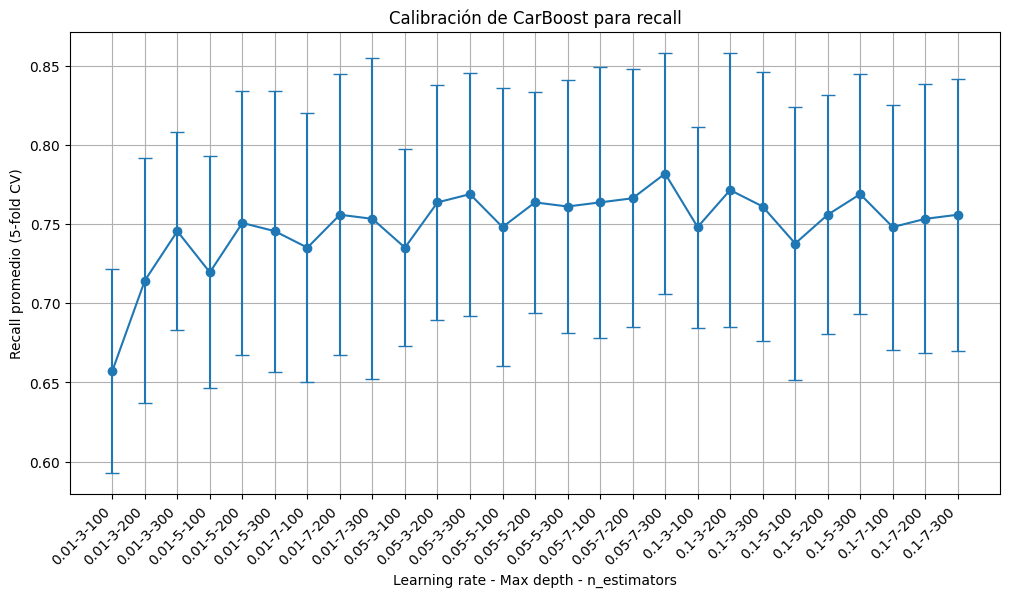

In [ ]:
#!pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

learning_rates = [0.01, 0.05, 0.1]
depths = [3, 5, 7]
iterations = [100, 200, 300]

resultados = []

for lr in learning_rates:
    for d in depths:
        for it in iterations:
            modelo_cb = CatBoostClassifier(
                learning_rate=lr,
                depth=d,
                iterations=it,
                random_state=123
            )

            scores = cross_val_score(modelo_cb, x_train, y_train, cv=cv, scoring='recall', n_jobs=-1)
            resultados.append((lr, d, it, scores.mean(), scores.std()))

labels = [f"{lr}-{depth}-{n}" for lr, depth, n, _, _ in resultados]
recalls = [r for _, _, _, r, _ in resultados]
stds = [s for _, _, _, _, s in resultados]

plt.figure(figsize=(12,6))
plt.errorbar(labels, recalls, yerr=stds, fmt='-o', capsize=5)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Learning rate - Max depth - n_estimators")
plt.ylabel("Recall promedio (5-fold CV)")
plt.title("Calibración de CarBoost para recall")
plt.grid(True)
plt.show()

In [ ]:
model_catboost = CatBoostClassifier(learning_rate=0.05, depth=7, iterations=300, random_state=123)
model_catboost.fit(x_train, y_train)

y_preds_catboost = model_catboost.predict(x_test)
y_preds_catboost_proba = model_catboost.predict_proba(x_test)[:, 1]

recall_split_cb = recall_score(y_test,y_preds_catboost)
precision_split_cb = precision_score(y_test,y_preds_catboost)
f1_split_cb = f1_score(y_test,y_preds_catboost)
roc_auc_split_cb = roc_auc_score(y_test, y_preds_catboost_proba)

print("Recall Score:", recall_score(y_test,y_preds_catboost))
print("Precision Score:", precision_score(y_test,y_preds_catboost))
print("F1 Score:", f1_score(y_test,y_preds_catboost))
print("ROC-AUC:", roc_auc_score(y_test, y_preds_catboost_proba))

0:	learn: 0.6741012	total: 25.3ms	remaining: 7.55s
1:	learn: 0.6564150	total: 41.6ms	remaining: 6.2s
2:	learn: 0.6404719	total: 60.5ms	remaining: 5.99s
3:	learn: 0.6268572	total: 72.3ms	remaining: 5.35s
4:	learn: 0.6113272	total: 80.5ms	remaining: 4.75s
5:	learn: 0.5961572	total: 113ms	remaining: 5.55s
6:	learn: 0.5825718	total: 121ms	remaining: 5.08s
7:	learn: 0.5706589	total: 129ms	remaining: 4.71s
8:	learn: 0.5609073	total: 144ms	remaining: 4.64s
9:	learn: 0.5505454	total: 151ms	remaining: 4.38s
10:	learn: 0.5417599	total: 167ms	remaining: 4.38s
11:	learn: 0.5345731	total: 174ms	remaining: 4.18s
12:	learn: 0.5267329	total: 182ms	remaining: 4.01s
13:	learn: 0.5182034	total: 216ms	remaining: 4.42s
14:	learn: 0.5121062	total: 235ms	remaining: 4.47s
15:	learn: 0.5056687	total: 246ms	remaining: 4.37s
16:	learn: 0.4999632	total: 260ms	remaining: 4.33s
17:	learn: 0.4935715	total: 272ms	remaining: 4.27s
18:	learn: 0.4889885	total: 285ms	remaining: 4.22s
19:	learn: 0.4847230	total: 299ms	rem

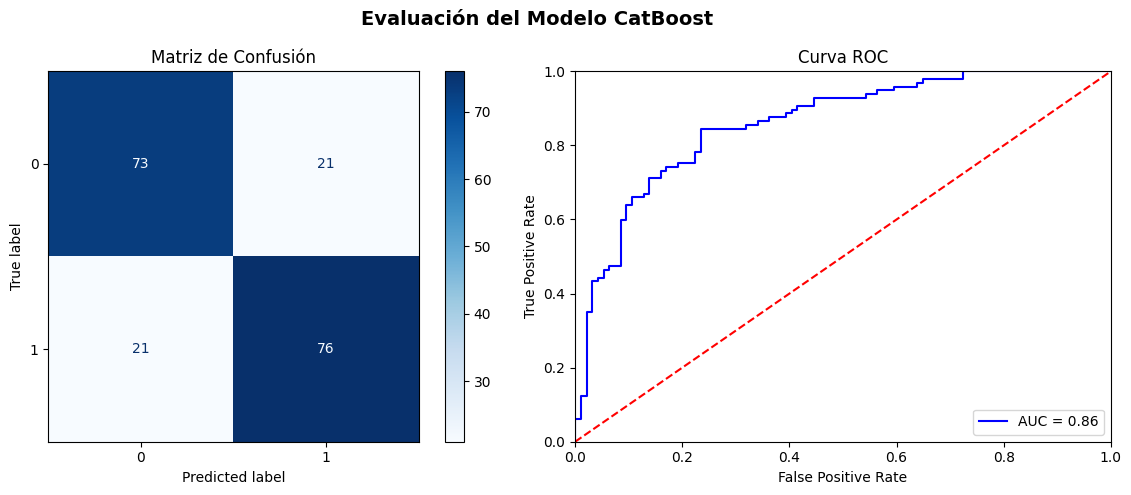

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

probs = model_catboost.predict_proba(x_test)
preds_prob = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, preds_prob)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], 'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

preds = model_catboost.predict(x_test)
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Matriz de Confusión")

plt.suptitle("Evaluación del Modelo CatBoost", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
promedio_kfold = df_resultados_cb.iloc[-1]

tabla_comparativa = pd.DataFrame({
    'Método': ['Train/Test Split', 'K-Fold (5)'],
    'Recall': [recall_split_cb, promedio_kfold['Recall']],
    'Precision': [precision_split_cb, promedio_kfold['Precision']],
    'F1': [f1_split_cb, promedio_kfold['F1']],
    'ROC_AUC': [roc_auc_split_cb, promedio_kfold['ROC_AUC']]
})

tabla_comparativa

,Método,Recall,Precision,F1,ROC_AUC
0,Train/Test Split,0.783505,0.783505,0.783505,0.859618
1,K-Fold (5),0.781818,0.754272,0.766173,0.832358


### **Análisis comparativo en el modelo CatBoost**
En el modelo CatBoost, las métricas del K-Fold son ligeramente menores que las del Train/Test Split, lo que indica que la validación cruzada ofrece una estimación más realista de la generalización. Aunque el Recall se mantiene alto (0.7818), la Precision baja un poco (0.7543), lo que refleja que el modelo sigue detectando correctamente la mayoría de anomalías, pero con un leve aumento de falsos positivos. El F1 y el ROC-AUC muestran que CatBoost logra un buen equilibrio entre sensibilidad y capacidad de discriminación, consolidándolo como el modelo más sólido comparandolo con todos los demás modelos anteriores.


## **Modelo 7: Lightgbm**

In [ ]:
#!pip install lightgbm
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
import pandas as pd

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

modelo_lgbm = LGBMClassifier(
    n_estimators=200,
    learning_rate=0.01,
    max_depth=5,
    random_state=123
)

scoring = {
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

resultados = cross_validate(modelo_lgbm, x_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)

df_resultados = pd.DataFrame({
    'Fold': range(1, cv.get_n_splits() + 1),
    'Recall': resultados['test_recall'],
    'Precision': resultados['test_precision'],
    'F1': resultados['test_f1'],
    'ROC_AUC': resultados['test_roc_auc']
})

promedios = df_resultados[['Recall', 'Precision','F1', 'ROC_AUC']].mean()
promedios['Fold'] = 'Promedio'
df_resultados_lgbm = pd.concat([df_resultados, pd.DataFrame([promedios])], ignore_index=True)

df_resultados_lgbm


,Fold,Recall,Precision,F1,ROC_AUC
0,1,0.857143,0.825000,0.840764,0.879870
1,2,0.701299,0.760563,0.729730,0.809467
2,3,0.662338,0.698630,0.680000,0.795113
3,4,0.870130,0.761364,0.812121,0.842771
4,5,0.857143,0.758621,0.804878,0.885714
5,Promedio,0.789610,0.760836,0.773499,0.842587


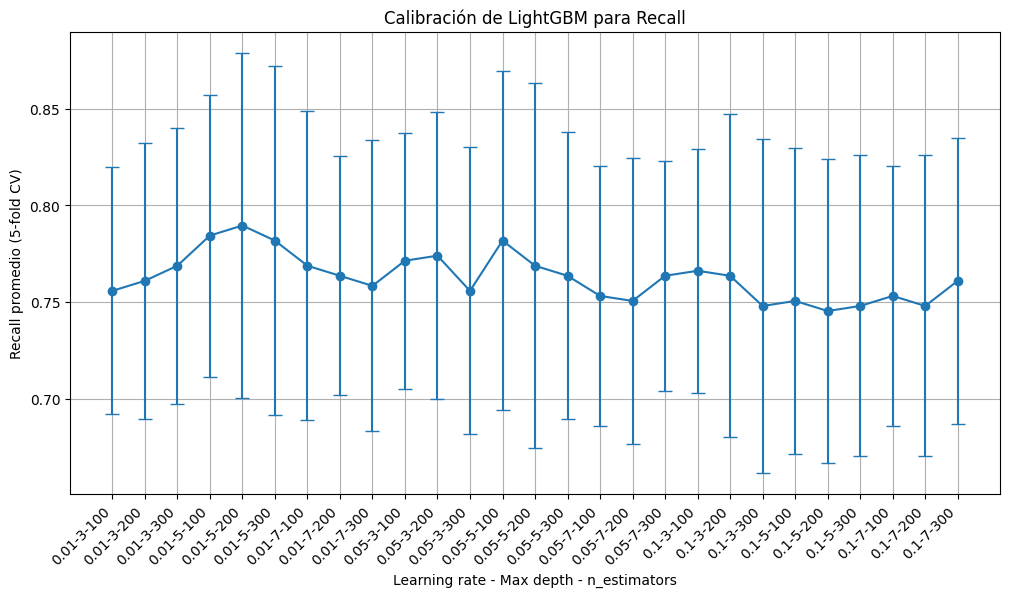

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

learning_rates = [0.01, 0.05, 0.1]
depths = [3, 5, 7]
n_estimators = [100, 200, 300]

resultados = []

for lr in learning_rates:
    for d in depths:
        for ne in n_estimators:
            modelo_lgb = LGBMClassifier(
                learning_rate=lr,
                max_depth=d,
                n_estimators=ne,
                random_state=123
            )

            scores = cross_val_score(modelo_lgb, x_train, y_train, cv=cv, scoring='recall', n_jobs=-1)
            resultados.append((lr, d, ne, scores.mean(), scores.std()))

labels = [f"{lr}-{depth}-{n}" for lr, depth, n, _, _ in resultados]
recalls = [r for _, _, _, r, _ in resultados]
stds = [s for _, _, _, _, s in resultados]

plt.figure(figsize=(12,6))
plt.errorbar(labels, recalls, yerr=stds, fmt='-o', capsize=5)
plt.xticks(rotation=45, ha='right')
plt.xlabel("Learning rate - Max depth - n_estimators")
plt.ylabel("Recall promedio (5-fold CV)")
plt.title("Calibración de LightGBM para Recall")
plt.grid(True)
plt.show()


In [ ]:
modelo_lgbm = LGBMClassifier(learning_rate=0.01, max_depth=5, n_estimators=200, random_state=123, verbose=-1)
modelo_lgbm.fit(x_train, y_train)

y_preds_lgbm = modelo_lgbm.predict(x_test)
y_preds_lgbm_proba = modelo_lgbm.predict_proba(x_test)[:, 1]

recall_split_lgbm = recall_score(y_test,y_preds_lgbm)
precision_split_lgbm = precision_score(y_test,y_preds_lgbm)
f1_split_lgbm = f1_score(y_test,y_preds_lgbm)
roc_auc_split_lgbm = roc_auc_score(y_test, y_preds_lgbm_proba)

print("Recall Score:", recall_score(y_test,y_preds_lgbm))
print("Precision Score:", precision_score(y_test,y_preds_lgbm))
print("F1 Score:", f1_score(y_test,y_preds_lgbm))
print("ROC-AUC:", roc_auc_score(y_test, y_preds_lgbm_proba))

Recall Score: 0.8041237113402062
Precision Score: 0.7722772277227723
F1 Score: 0.7878787878787878
ROC-AUC: 0.846018863785918


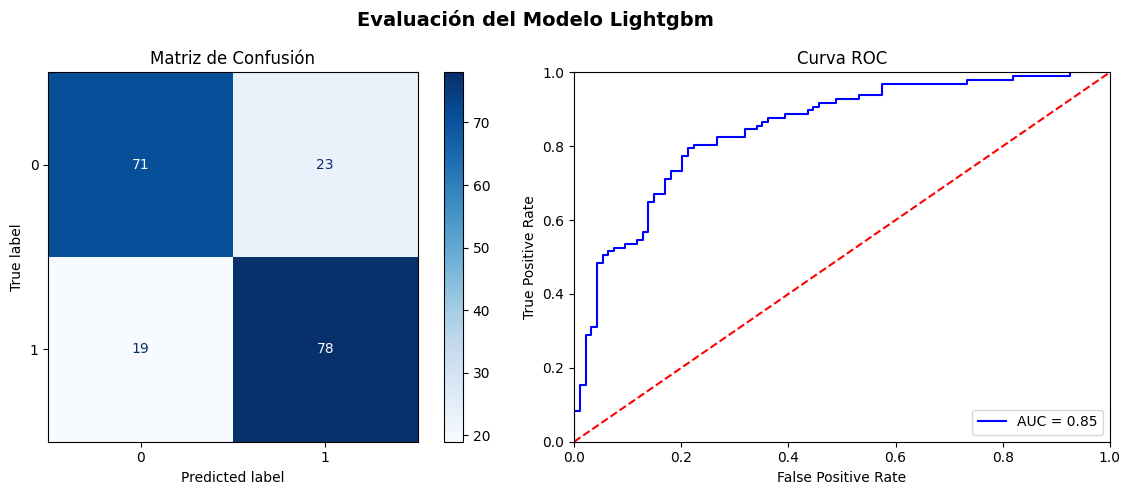

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

probs = modelo_lgbm.predict_proba(x_test)
preds_prob = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, preds_prob)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], 'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_title("Curva ROC")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

preds = modelo_lgbm.predict(x_test)
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Matriz de Confusión")

plt.suptitle("Evaluación del Modelo Lightgbm", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
promedio_kfold = df_resultados_lgbm.iloc[-1]

tabla_comparativa = pd.DataFrame({
    'Método': ['Train/Test Split', 'K-Fold (5)'],
    'Recall': [recall_split_lgbm, promedio_kfold['Recall']],
    'Precision': [precision_split_lgbm, promedio_kfold['Precision']],
    'F1': [f1_split_lgbm, promedio_kfold['F1']],
    'ROC_AUC': [roc_auc_split_lgbm, promedio_kfold['ROC_AUC']]
})

tabla_comparativa

,Método,Recall,Precision,F1,ROC_AUC
0,Train/Test Split,0.804124,0.772277,0.787879,0.846019
1,K-Fold (5),0.789610,0.760836,0.773499,0.842587


### **Análisis comparativo en el modelo LightGBM**
En LightGBM, se observa que las métricas del K-Fold son ligeramente menores que las del Train/Test Split, indicando que la validación cruzada proporciona una estimación más conservadora de la generalización. El Recall alto (0.7896) muestra que el modelo sigue detectando la mayoría de las anomalías, mientras que la Precision (0.7608) refleja un pequeño aumento de falsos positivos. El F1 y ROC-AUC sugieren que LightGBM mantiene un buen equilibrio entre sensibilidad y capacidad de discriminación, siendo un modelo sólido incluso con el anteriormente evaluado CatBoost

## **Conclusiones Finales**

Depues de observar y evaluar los 7 modelos implementados se muestra en esta tabla todos los resultados con las métricas que se usaron para evaluar cada modelo:

In [ ]:
import pandas as pd

modelos = ["KNN", "SVM", "RandomForest", "XGBoost","LightGBM", "CatBoost", "RegLogistica"]

recall_kfold = [0.8104, 0.7688, 0.7662, 0.7688, 0.7896, 0.7818, 0.7584]
precision_kfold = [0.7035, 0.7570, 0.7678, 0.7550, 0.7608, 0.7543, 0.7589]
f1_fold = [0.7523, 0.7626, 0.7652, 0.7600, 0.7735, 0.7662, 0.7579]
rocauc_kfold = [0.7997, 0.8226, 0.8407, 0.8231, 0.8426, 0.8324, 0.8219]

recall_test = [0.7835, 0.7938, 0.7732, 0.8144, 0.8041, 0.7835, 0.7732]
precision_test = [0.7308, 0.7549, 0.7575, 0.7745, 0.7723, 0.7835, 0.7576]
f1_test = [0.7562, 0.7739, 0.7653, 0.7940, 0.7879, 0.7835, 0.7653]
rocauc_test = [0.8434, 0.8208, 0.8545, 0.8448, 0.8460, 0.8596, 0.8292]
df_comparativo = pd.DataFrame({
    "Modelo": modelos,
    "Recall K-Fold": recall_kfold,
    "Precision K-Fold": precision_kfold,
    "F1 K-Fold": f1_fold,
    "ROC-AUC K-Fold": rocauc_kfold,
    "Recall Test": recall_test,
    "Precision Test": precision_test,
    "F1 Test": f1_test,
    "ROC-AUC Test": rocauc_test
})

df_comparativo


,Modelo,Recall K-Fold,Precision K-Fold,F1 K-Fold,ROC-AUC K-Fold,Recall Test,Precision Test,F1 Test,ROC-AUC Test
0,KNN,0.8104,0.7035,0.7523,0.7997,0.7835,0.7308,0.7562,0.8434
1,SVM,0.7688,0.7570,0.7626,0.8226,0.7938,0.7549,0.7739,0.8208
2,RandomForest,0.7662,0.7678,0.7652,0.8407,0.7732,0.7575,0.7653,0.8545
3,XGBoost,0.7688,0.7550,0.7600,0.8231,0.8144,0.7745,0.7940,0.8448
4,LightGBM,0.7896,0.7608,0.7735,0.8426,0.8041,0.7723,0.7879,0.8460
5,CatBoost,0.7818,0.7543,0.7662,0.8324,0.7835,0.7835,0.7835,0.8596
6,RegLogistica,0.7584,0.7589,0.7579,0.8219,0.7732,0.7576,0.7653,0.8292


## ¿Cuál es el mejor modelo?
Después de haber evaluado los siete modelos anteriormente propuestos bajo la validación cruzada y pruebas finales sobre el conjunto de test, se puede observar que el modelo con mejor desempeño en general fue el de K-Nearest Neighbors (KNN) el cual obtuvo el mayor recall promedio con 0.8104, seguido de Random Forest y LightGBM. Lo malo de KNN es que tiene un ROC-AUC demasiado bajo comparado con los demás modelos lo que se interpreta que no clasifica bien las clases comparado con otros algoritmos.

Por otro lado LightGBM y Random Forest tienen un mejor equilibrio global: LightGBM alcanzó valores altos en recall (0.7896) como en ROC-AUC (0.8426), lo mismo sucede con Random Forest que obtuvo metricas similares (recall = 0.7662, ROC-AUC = 0.8407).

Cabe aclarar que comparamos los modelos con el promedio de las metricas obtenidos de la validación cruzada ya que estos datos me permiten evaluar al modelo de manera más estable. Ya que a diferencia de un único split de entrenamiento y prueba, la validación cruzada reduce la influencia al azar en la partición de los datos y proporciona una estimación más confiable del desempeño real del modelo. La validación final con el test es más que nada para ver si el modelo no generaliza o si hubo sobreajuste con los datos del entrenamiento.

Luego en la validación con el conjunto de datos de test, LightGBM tuvo un excelente rendimiento general (recall = 0.8041, F1 = 0.7879, ROC-AUC = 0.8460), esto confirmando su capacidad de generalización sin una caída significativa de desempeño. Por su parte, aunque el modelo CatBoost obtuvo el mayor ROC-AUC en la evaluación final con el conjunto test (0.8596), su recall promedio en la validación cruzada fue menor (0.7818), lo que lo hace menos consistente con la métrica principal.

Por ende, LightGBM con sus hiperparametros calibrados lo elegimos como el mejor modelo, ya que ofrece un equilibrio óptimo entre todas las métricas usadas, con un rendimiento estable tanto en la validación cruzada como en la evaluación final. Estos datos lo convierten en la opción más adecuada para nuestro problema de detección de frames anómalos, donde la clave es detectar la mayor cantidad posible de eventos inusuales manteniendo un leve control con las falsas alarmas.